### Description of the model

For the three coupled rings, R1, R2, and R3. The first ring, represent sesonry areas which directly receives subcortical stimulus-related input. The middle ring R2 receives long-range feed-forward input from R1, and the top ring R3 from R2. The couplings from R1 to R2 and R2 to R3 have identical strengths and widths. We deliberately do not introduce any structural feedback coupling to study the capacity of information-theoretical metrics to capture the primitive processing operation of propagating and transferring information through a multi-regional directed hierarchy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from numba import *
from tqdm import tqdm

#### Import core model functions

In [2]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/nicole_model")

In [3]:
from src.integration import config_simulation
from src.model import create_ring, dRdt, set_external_ring_coupling
from src.utils import batch

In [4]:
def simulate_three_rings(
    state=["SU", "SU", "SU"],
    integration="euler",
    N=100,
    trials=1,
    h=0.01,
    tsim=10.0,
    trans=5.5,
    delay=10,
    delay_lr=20,
    decim=10,
    s_pos=0,
    s_on=0,
    s_off=0,
    A_stim=0,
    sig_stim=1,
    batch_size=1,
    verbose=False,
):

    assert isinstance(state, (list, np.array, tuple))

    fint, steps, times = config_simulation(integration, tsim, h)

    s_on = [int(onset / h) for onset in s_on]
    s_off = [int(offset / h) for offset in s_off]

    # Create first ring
    J1, Iext1, Istim1, theta1, R1 = create_ring(
        state=state[0],
        N=N,
        trials=trials,
        steps=steps,
        s_pos=s_pos,
        s_on=s_on,
        s_off=s_off,
        A_stim=A_stim,
        sig_stim=sig_stim,
    )
    # Create second ring
    J2, Iext2, Istim2, theta2, R2 = create_ring(
        state=state[1],
        N=N,
        trials=trials,
        steps=steps,
        s_pos=s_pos,
        s_on=s_on,
        s_off=s_off,
        A_stim=0,
        sig_stim=sig_stim,
    )

    # Create second ring
    J3, Iext3, Istim3, theta3, R3 = create_ring(
        state=state[2],
        N=N,
        trials=trials,
        steps=steps,
        s_pos=s_pos,
        s_on=s_on,
        s_off=s_off,
        A_stim=0,
        sig_stim=sig_stim,
    )

    # Define feedforward coupling
    J12 = set_external_ring_coupling(N, 35 / N, 3)
    # Define feedback coupling
    J23 = set_external_ring_coupling(N, 35 / N, 3)

    # Index of each trial
    trials_idx = np.arange(0, trials, dtype=int)

    def _simulate_batch(i_):
        R1[i_, : delay + 1] = np.random.uniform(0, 0.1, size=R1[i_, : delay + 1].shape)
        R2[i_, : delay + 1] = np.random.uniform(0, 0.1, size=R2[i_, : delay + 1].shape)
        R3[i_, : delay + 1] = np.random.uniform(0, 0.1, size=R3[i_, : delay + 1].shape)
        # Solve the ODE using RK4
        for t in range(delay, steps):
            R1[i_, t, :] = fint(
                dRdt,
                R1[i_, t - 1, :],
                times[t],
                h,
                Iext1[i_, t],
                Istim1[t],
                R1[i_, t - delay, :] @ J1,
            )
            R2[i_, t, :] = fint(
                dRdt,
                R2[i_, t - 1, :],
                times[t],
                h,
                Iext2[i_, t],
                0.0,
                R2[i_, t - delay, :] @ J2 + R1[i_, t - delay_lr, :] @ J12,
            )
            R3[i_, t, :] = fint(
                dRdt,
                R3[i_, t - 1, :],
                times[t],
                h,
                Iext3[i_, t],
                0.0,
                R3[i_, t - delay, :] @ J3 + R2[i_, t - delay_lr, :] @ J23,
            )

    # Simulate trial batches
    nbatches = int(trials / batch_size)
    pbar = batch(trials_idx, n=batch_size)

    if verbose:
        pbar = tqdm(pbar)

    n = 1
    for indexes in pbar:
        _simulate_batch(indexes)
        if verbose:
            pbar.set_description(f"Simulating trials batch {n}/{nbatches}")
            n = n + 1

    # Apply decimation
    if isinstance(decim, int):
        times = times[::decim]
        R1 = R1[:, ::decim, :]
        R2 = R2[:, ::decim, :]
        R3 = R3[:, ::decim, :]

    trans = int(trans / (decim * h))
    # Discard transient
    R1 = R1[:, trans:, :]
    R2 = R2[:, trans:, :]
    R3 = R3[:, trans:, :]

    R1 = xr.DataArray(
        R1,
        dims=("trials", "times", "nodes"),
        coords=(trials_idx, times[:-trans], theta1),
    )

    R2 = xr.DataArray(
        R2,
        dims=("trials", "times", "nodes"),
        coords=(trials_idx, times[:-trans], theta2),
    )

    R3 = xr.DataArray(
        R3,
        dims=("trials", "times", "nodes"),
        coords=(trials_idx, times[:-trans], theta3),
    )

    # Discard transient
    R1 = R1.sel(times=slice(trans))
    R2 = R2.sel(times=slice(trans))
    R3 = R3.sel(times=slice(trans))

    return R1, R2, R3

##### SU

In [5]:
R1, R2, R3 = simulate_three_rings(
    state=["SU", "SU", "SU"],
    integration="rk4",
    tsim=45 + 40,
    trans=40,
    trials=50,
    batch_size=25,
    verbose=True,
    decim=10,
    s_pos=[50],
    s_on=[10 + 40],
    s_off=[25 + 40],
    A_stim=2.0,
    sig_stim=8,
)

Simulating trials batch 2/2: : 2it [00:04,  2.39s/it]


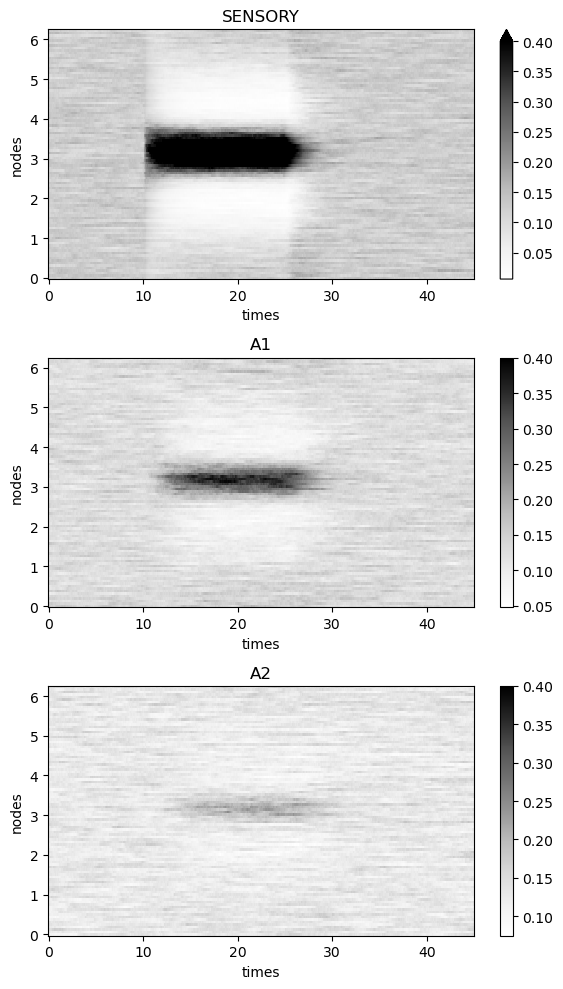

In [6]:
plt.figure(figsize=(6, 10))
plt.subplot(311)
R1.sel(trials=20).plot(x="times", cmap="Greys", vmax=0.4)
plt.title("SENSORY")
plt.subplot(312)
R2.sel(trials=20).plot(x="times", cmap="Greys", vmax=0.4)
plt.title("A1")
plt.subplot(313)
R3.sel(trials=20).plot(x="times", cmap="Greys", vmax=0.4)
plt.title("A2")
plt.tight_layout()

##### SB

In [7]:
R1, R2, R3 = simulate_three_rings(
    state=["SB", "SB", "SB"],
    integration="rk4",
    tsim=45 + 40,
    trans=40,
    trials=50,
    batch_size=25,
    verbose=True,
    decim=10,
    s_pos=[50],
    s_on=[10 + 40],
    s_off=[25 + 40],
    A_stim=2.0,
    sig_stim=8,
)

Simulating trials batch 2/2: : 2it [00:05,  2.52s/it]


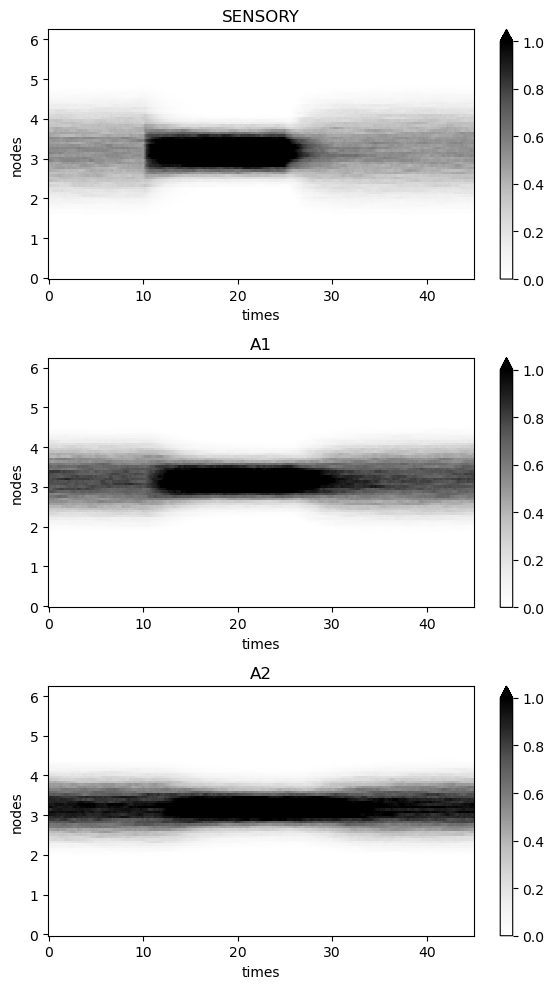

In [8]:
plt.figure(figsize=(6, 10))
plt.subplot(311)
R1.sel(trials=10).plot(x="times", cmap="Greys", vmax=1)
plt.title("SENSORY")
plt.subplot(312)
R2.sel(trials=10).plot(x="times", cmap="Greys", vmax=1)
plt.title("A1")
plt.subplot(313)
R3.sel(trials=10).plot(x="times", cmap="Greys", vmax=1)
plt.title("A2")
plt.tight_layout()

#### IPP analysis

In [9]:
# Stimulus positions
Spos = np.array([0, 25, 50, 75])

In [10]:
RSU = []

R1, R2, R3 = [], [], []

for spos in Spos:

    R1_temp, R2_temp, R3_temp = simulate_three_rings(
        state=["SB"] * 3,
        integration="rk4",
        tsim=45 + 40,
        trans=40,
        trials=300,
        batch_size=100,
        verbose=True,
        decim=10,
        s_pos=[spos],
        s_on=[10 + 40],
        s_off=[25 + 40],
        A_stim=2.0,
        sig_stim=8,
    )

    R1 += [R1_temp]
    R2 += [R2_temp]
    R3 += [R3_temp]

R1 = xr.concat(R1, "trials").assign_coords({"trials": range(len(Spos) * 300)})
R2 = xr.concat(R2, "trials").assign_coords({"trials": range(len(Spos) * 300)})
R3 = xr.concat(R3, "trials").assign_coords({"trials": range(len(Spos) * 300)})

Simulating trials batch 3/3: : 3it [00:22,  7.49s/it]
Simulating trials batch 3/3: : 3it [00:22,  7.45s/it]
Simulating trials batch 3/3: : 3it [00:22,  7.53s/it]
Simulating trials batch 3/3: : 3it [00:21,  7.33s/it]


In [11]:
from src.infodyn.conn_pid import conn_pid

In [12]:
stim = np.repeat(Spos, 300)

In [13]:
nodes1 = [f"{i}_1" for i in range(100)]
nodes2 = [f"{i}_2" for i in range(100)]
nodes3 = [f"{i}_3" for i in range(100)]

In [14]:
R1 = R1.assign_coords({"nodes": nodes1})
R2 = R2.assign_coords({"nodes": nodes2})
R3 = R3.assign_coords({"nodes": nodes3})

In [15]:
from frites.conn import conn_te

In [16]:
pairs = np.stack((range(100), range(100, 200)), 1)

##### TE(R1->R2)

In [17]:
R12 = xr.concat((R1, R2), "nodes")

In [18]:
te12 = conn_te(
    R12.transpose("trials", "nodes", "times"),
    R12.times.data,
    roi="nodes",
    verbose=True,
    pairs=pairs,
    n_jobs=20,
)

Defining links (n_roi=200; directed=True; net=False, nb_min_links=None)
Compute Transfer Entropy (n_pairs=100, delays=[0:1:30])
/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                           | Estimating TE : 0/100 [00:00<?,       ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
 40%|████████████████████████████                                          | Estimating TE : 40/100 [00:03<00:04,   12.70it/s][Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.2s
100%|█████████████████████████████████████████████████████████████████████| Estimating TE : 100/100 [00:05<00:00,   17.88it/s]
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    6.6s finished


In [19]:
R21 = xr.concat((R2, R1), "nodes")

In [20]:
te21 = conn_te(
    R21.transpose("trials", "nodes", "times"),
    R21.times.data,
    roi="nodes",
    verbose=True,
    pairs=pairs,
    n_jobs=20,
)

Defining links (n_roi=200; directed=True; net=False, nb_min_links=None)
Compute Transfer Entropy (n_pairs=100, delays=[0:1:30])
  0%|                                                                           | Estimating TE : 0/100 [00:00<?,       ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
 40%|████████████████████████████                                          | Estimating TE : 40/100 [00:00<00:01,   55.53it/s][Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.9s
100%|█████████████████████████████████████████████████████████████████████| Estimating TE : 100/100 [00:03<00:00,   31.60it/s]
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    4.1s finished


In [21]:
R23 = xr.concat((R2, R3), "nodes")

In [22]:
te23 = conn_te(
    R23.transpose("trials", "nodes", "times"),
    R23.times.data,
    roi="nodes",
    verbose=True,
    pairs=pairs,
    n_jobs=20,
)

Defining links (n_roi=200; directed=True; net=False, nb_min_links=None)
Compute Transfer Entropy (n_pairs=100, delays=[0:1:30])
  0%|                                                                           | Estimating TE : 0/100 [00:00<?,       ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
 40%|████████████████████████████                                          | Estimating TE : 40/100 [00:00<00:01,   54.27it/s][Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
100%|█████████████████████████████████████████████████████████████████████| Estimating TE : 100/100 [00:03<00:00,   31.84it/s]
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    4.1s finished


In [23]:
R32 = xr.concat((R3, R2), "nodes")

In [24]:
te32 = conn_te(
    R32.transpose("trials", "nodes", "times"),
    R32.times.data,
    roi="nodes",
    verbose=True,
    pairs=pairs,
    n_jobs=20,
)

Defining links (n_roi=200; directed=True; net=False, nb_min_links=None)
Compute Transfer Entropy (n_pairs=100, delays=[0:1:30])
  0%|                                                                           | Estimating TE : 0/100 [00:00<?,       ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
 40%|████████████████████████████                                          | Estimating TE : 40/100 [00:00<00:01,   55.57it/s][Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
100%|█████████████████████████████████████████████████████████████████████| Estimating TE : 100/100 [00:03<00:00,   31.82it/s]
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    4.1s finished


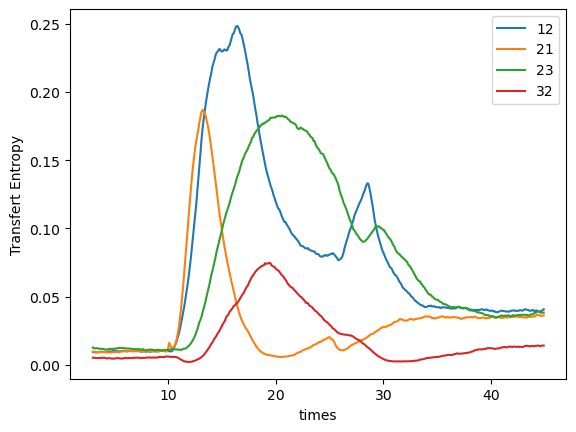

In [25]:
te12.mean("roi").plot()
te21.mean("roi").plot()
te23.mean("roi").plot()
te32.mean("roi").plot()
plt.legend(["12", "21", "23", "32"])

In [26]:
from frites.core import gccmi_nd_ccc  # TE
from frites.core import gcmi_model_nd_cd  # M(R(t),Spos)
from frites.core import gcmi_nd_cc  # M(R(t),S(t)) or M(R,Rpast)

In [27]:
TE12 = gccmi_nd_ccc(
    R2.data[:, :-10, :], R1.data[:, 10:, :], R2.data[:, 10:, :], traxis=0, mvaxis=2
)

TE21 = gccmi_nd_ccc(
    R1.data[:, 10:, :], R2.data[:, :-10, :], R1.data[:, :-10, :], traxis=0, mvaxis=2
)

TE23 = gccmi_nd_ccc(
    R3.data[:, :-10, :], R2.data[:, 10:, :], R3.data[:, 10:, :], traxis=0, mvaxis=2
)


TE32 = gccmi_nd_ccc(
    R2.data[:, 10:, :], R3.data[:, :-10, :], R2.data[:, :-10, :], traxis=0, mvaxis=2
)

Text(0.5, 1.0, 'SB')

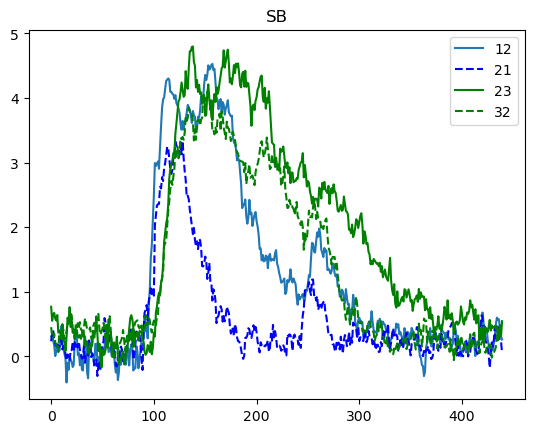

In [28]:
plt.plot(TE12)
plt.plot(TE21, "b--")
plt.plot(TE23, "g")
plt.plot(TE32, "g--")
plt.legend(["12", "21", "23", "32"])
plt.title("SB")